# GEM and Sampling Analysis


In [1]:
from common_variables import *
resave_figures = False # Turn to True to save figures

Data loading complete!
Data loaded into DATA dictionary.


In [2]:
def loadSamples(binary_rxns_df, samples_dir, sampler='RHMC'):
    # Pre-compute reaction info once
    reaction_info = {
        'Reactions': binary_rxns_df['Reactions'].values,
        'ReactionNames': binary_rxns_df['ReactionNames'].values,
        'subSystems_og': binary_rxns_df['subSystems_og'].values,
        'subSystems': binary_rxns_df['subSystems'].values,
        'rxnFormula': binary_rxns_df['rxnFormulas'].values
    }
    
    # Get model names and create lookup for active reactions
    model_names = binary_rxns_df.columns[~binary_rxns_df.columns.isin(['Reactions', 'ReactionNames', 'subSystems_og', 'subSystems', 'rxnFormulas'])]
    active_reactions_mask = {model: binary_rxns_df[model].values == 1 for model in model_names}
    
    # Initialize markers and tracking arrays
    reaction_activity = np.zeros(len(reaction_info['Reactions']), dtype=bool)
    
    # Dictionary to store samples temporarily
    temp_samples = {}
    
    # First pass: load samples and track non-zero reactions
    for model in model_names:
        try:
            # Load and process samples
            samples_file = os.path.join(samples_dir, f'{sampler}_{model}.csv')
            samples = pd.read_csv(samples_file, header=None).values  # Convert to numpy array immediately
            
            # Get active reactions for this model
            model_active_mask = active_reactions_mask[model]
            active_indices = np.where(model_active_mask)[0]
            
            # Check which samples have non-zero values
            nonzero_samples = np.any(samples != 0, axis=1)
            
            # Update reaction activity tracking for active reactions
            for sample_idx, global_idx in enumerate(active_indices):
                if nonzero_samples[sample_idx]:
                    reaction_activity[global_idx] = True
            
            # Store samples
            temp_samples[model] = (samples, active_indices)
            
            
        except FileNotFoundError:
            print(f"Warning: No sample file found for {model}")
            continue
    
    print(f"Loaded samples for {sampler}.")
    
    # Get indices of reactions that have non-zero values
    active_indices = np.where(reaction_activity)[0]
    
    # Create mapping from old indices to new indices
    old_to_new_idx = {old_idx: new_idx for new_idx, old_idx in enumerate(active_indices)}
    
    # Create final data structures
    samples_data = {}
    for model in temp_samples:
        samples, model_active_indices = temp_samples[model]
        n_samples = samples.shape[1]
        
        # Create aligned samples array
        aligned_samples = np.zeros((len(active_indices), n_samples))
        
        # Map active reactions to their positions in the filtered set
        for i, global_idx in enumerate(model_active_indices):
            if global_idx in old_to_new_idx:  # Only copy if reaction is active
                new_idx = old_to_new_idx[global_idx]
                aligned_samples[new_idx] = samples[i]
        
        # Create reaction mappings for active reactions only
        active_reactions = reaction_info['Reactions'][active_indices]
        active_names = reaction_info['ReactionNames'][active_indices]
        active_subsystems_og = reaction_info['subSystems_og'][active_indices] 
        active_subsystems = reaction_info['subSystems'][active_indices] 
        
        # Store final data
        samples_data[model] = {
            'samples': pd.DataFrame(aligned_samples),
            'reactionNames': {i: name for i, name in enumerate(active_names)},
            'reactionIDs': {i: rxn for i, rxn in enumerate(active_reactions)},
            'subSystems_og': {i: subsys_og for i, subsys_og in enumerate(active_subsystems_og)},
            'subSystems': {i: subsys for i, subsys in enumerate(active_subsystems)}
        }
        
    print(f"{len(active_indices)} commonly active reactions "
            f"(filtered from {len(reaction_info['Reactions'])} total)")
    
    return samples_data
 
samples_data_corners = loadSamples(DATA['binary_rxns'], DATA['paths']['dir_samples'], sampler='RAVENCorners') # this is pre-normalization by biomass
samples_data = loadSamples(DATA['binary_rxns'], DATA['paths']['dir_samples'], sampler='FilteredRHMC')


Loaded samples for RAVENCorners.
7888 commonly active reactions (filtered from 13213 total)
Loaded samples for FilteredRHMC.
8752 commonly active reactions (filtered from 13213 total)


In [3]:
def findDifferentialReactionsTvsN(samples_data, markers, ignore_transport=False, 
                                     pvalue_threshold=0.01, log2fc_threshold=5.0, 
                                     effect_size_threshold=0.5, distance_threshold=5):
    if isinstance(markers, str):
        markers = [markers]
    
    # Initialize list to store results for each marker
    all_results = []
    
    for marker in markers:
        
        # Find normal and tumor keys for this marker
        normal_key = next(k for k in samples_data.keys() if marker in k and 'Normal' in k)
        tumor_key = next(k for k in samples_data.keys() if marker in k and 'Tumor' in k)
        
        # Get samples and reaction info directly from samples_data
        normal_samples = samples_data[normal_key]['samples']
        tumor_samples = samples_data[tumor_key]['samples']
        reaction_names = samples_data[normal_key]['reactionNames']
        reaction_ids = samples_data[normal_key]['reactionIDs']
        subSystems_og = samples_data[normal_key]['subSystems_og']
        subsystems = samples_data[normal_key]['subSystems']
        
        # Initialize lists for statistical results
        stats_results = []
        all_pvalues = []
        
        # Filter transport reactions if requested
        if ignore_transport:
            transport_keywords = {'transport', 'exchange', 'diffusion'}
            transport_mask = [
                not any(keyword.lower() in str(name).lower() for keyword in transport_keywords) and
                not any(keyword.lower() in str(subsys).lower() for keyword in transport_keywords)
                for name, subsys in zip(reaction_names.values(), subsystems.values())
            ]
        else:
            transport_mask = [True] * len(reaction_names)
        
        # Process each reaction
        for idx in range(len(reaction_ids)):
            if not transport_mask[idx]:
                continue
                
            normal_data = normal_samples.iloc[idx]
            tumor_data = tumor_samples.iloc[idx]
            
            # Basic statistics
            normal_mean = normal_data.mean()
            tumor_mean = tumor_data.mean()
            normal_std = normal_data.std()
            tumor_std = tumor_data.std()
            
            # Calculate fold change and log2 fold change np.log2(fold_change)
            fold_change = tumor_mean / normal_mean if normal_mean != 0 else float('inf')
            log2_fold_change = np.log2(fold_change) if fold_change > 0 else float('nan')
            
            # Calculate Wasserstein distance
            wasserstein_dist = wasserstein_distance(normal_data, tumor_data)
            
            # Perform Mann-Whitney U test
            try:
                statistic, p_value = stats.mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
            except ValueError:  # Handles cases where all values are identical
                p_value = 1.0
            
            # Calculate Cohen's d effect size
            pooled_std = np.sqrt((normal_std**2 + tumor_std**2) / 2)
            cohens_d = (tumor_mean - normal_mean) / pooled_std if pooled_std != 0 else 0
            
            # Store results
            result = {
                'marker': marker,
                'reaction_id': reaction_ids[idx],
                'reaction_name': reaction_names[idx],
                'subSystems_og': subSystems_og[idx],
                'subsystem': subsystems[idx],
                'normal_mean': normal_mean,
                'tumor_mean': tumor_mean,
                'normal_std': normal_std,
                'tumor_std': tumor_std,
                'fold_change': fold_change,
                'log2_fold_change': log2_fold_change,
                'wasserstein_dist': wasserstein_dist,
                'p_value': p_value,
                'cohens_d': abs(cohens_d)  # Use absolute value for effect size
            }
            
            stats_results.append(result)
            all_pvalues.append(p_value)
        
        # Convert to DataFrame
        marker_results = pd.DataFrame(stats_results)
        
        # Calculate FDR-corrected p-values
        _, adjusted_pvalues = fdrcorrection(all_pvalues, alpha=pvalue_threshold, method='indep')
        marker_results['adjusted_p_value'] = adjusted_pvalues
        
        # Add significance flags
        marker_results['sig_pvalue'] = marker_results['adjusted_p_value'] < pvalue_threshold
        marker_results['sig_log2fc'] = abs(marker_results['log2_fold_change']) >= log2fc_threshold
        marker_results['sig_effect'] = marker_results['cohens_d'] >= effect_size_threshold
        marker_results['sig_dist'] = marker_results['wasserstein_dist'] >= distance_threshold
        
        # Combined significance
        marker_results['significant'] = (
            marker_results['sig_pvalue'] & 
            marker_results['sig_log2fc'] & 
            marker_results['sig_effect'] & 
            marker_results['sig_dist']
        )
        
        # Add direction of change
        marker_results['direction'] = np.where(
            marker_results['log2_fold_change'] > 0,
            'up',
            'down'
        )
        
        # Print summary statistics
        n_significant = marker_results['significant'].sum()
        n_up = sum((marker_results['significant']) & (marker_results['direction'] == 'up'))
        n_down = sum((marker_results['significant']) & (marker_results['direction'] == 'down'))
        
        print(f"Results for {marker}: Significant reactions: {n_significant} (Up-regulated: {n_up} | Down-regulated: {n_down})")
        
        # Append results to main list
        all_results.append(marker_results)
    
    # Combine results from all markers
    if all_results:
        combined_results = pd.concat(all_results, axis=0, ignore_index=True)
        
        # Sort by significance and effect size
        combined_results = combined_results.sort_values(
            by=['significant', 'wasserstein_dist', 'cohens_d'],
            ascending=[False, False, False]
        )
        
        return combined_results
    else:
        print("No results to combine.")
        return None
    
## Calculate stats for all markers and save (commented out as already done)
# statistical_results_TvsN = findDifferentialReactionsTvsN(samples_data, markers=markers_all, ignore_transport=False, 
#                                                            pvalue_threshold=0.01, log2fc_threshold=2.0, 
#                                                            effect_size_threshold=0.5, distance_threshold=5)
# statistical_results_TvsN.sort_values(by=['marker', 'log2_fold_change'], ascending=[True, False]).to_excel('output/sampling_results_differential_rxns.xlsx', index=False)

# Output:
# Results for Malignant: Significant reactions: 161 (Up-regulated: 125 | Down-regulated: 36)
# Results for FGFR2+: Significant reactions: 71 (Up-regulated: 62 | Down-regulated: 9)
# Results for CD73+: Significant reactions: 99 (Up-regulated: 74 | Down-regulated: 25)
# Results for ICAM1+: Significant reactions: 86 (Up-regulated: 70 | Down-regulated: 16)
# Results for ICAM1-: Significant reactions: 75 (Up-regulated: 46 | Down-regulated: 29)
# Results for FAP+: Significant reactions: 114 (Up-regulated: 93 | Down-regulated: 21)
# Results for THBS1+: Significant reactions: 40 (Up-regulated: 36 | Down-regulated: 4)
# Results for VCAN+: Significant reactions: 97 (Up-regulated: 87 | Down-regulated: 10)
# Results for MARCO+: Significant reactions: 164 (Up-regulated: 150 | Down-regulated: 14)

statistical_results_TvsN = pd.read_excel('output/sampling_results_differential_rxns.xlsx', sheet_name='Sheet1')

##### **(A)** UMAP visualization showing cellular abundance in tumor-adjacent normal and tumor tissue, demonstrating enrichment of FAP+ fibroblasts and MARCO+ macrophages in tumor conditions. 

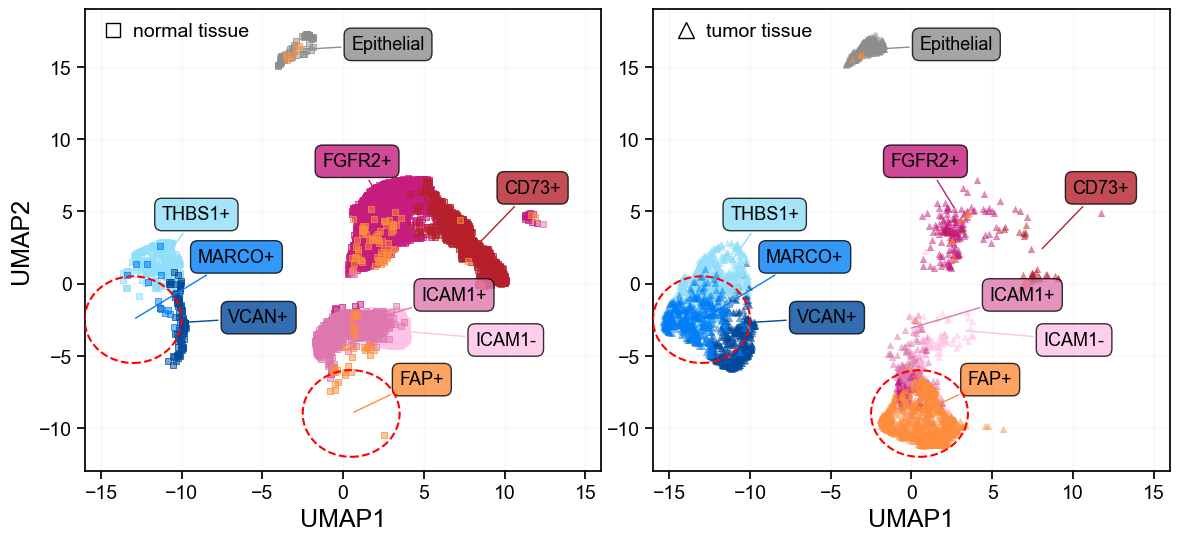

In [4]:
def scRNAplotUMAP(umap_csv_path, marker_colors, figsize=(14, 6)):

    # Load and prepare data
    umap_data = pd.read_csv(umap_csv_path)
    umap_data['marker'] = umap_data['Cell Types'].str.split().str[0]
    
    # Separate tissues and exclude markers
    exclude_markers = ['DES+', 'MFAP5+']  # myofibroblasts
    umap_data_n = umap_data[umap_data['Tissues'] == 'N']
    umap_data_t = umap_data[umap_data['Tissues'] == 'T']
    umap_data_n = umap_data_n[~umap_data_n['marker'].isin(exclude_markers)]
    umap_data_t = umap_data_t[~umap_data_t['marker'].isin(exclude_markers)]
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize, facecolor='#ffffff')
    
    # Define offset rules for normal tissue
    offset_rules_normal = {
        'FGFR2+': lambda x, y: (x - 4, y + 3),
        'Malignant': lambda x, y: (x + 3, y),
        'MARCO+': lambda x, y: (x + 4, y + 4),
        'THBS1+': lambda x, y: (x, y + 3),
        'VCAN+': lambda x, y: (x + 3, y ),
        'ICAM1+': lambda x, y: (x + 5, y + 2),
        'ICAM1-': lambda x, y: (x + 5, y-1),
        'CD73+': lambda x, y: (x + 2, y + 4),
        'FAP+': lambda x, y: (x + 3, y + 2),
        'default': lambda x, y: (x + 2, y + 2)
    }
    
    # Define offset rules for tumor tissue (same as normal in this case)
    offset_rules_tumor = {
        'FGFR2+': lambda x, y: (x - 4, y + 3),
        'Malignant': lambda x, y: (x + 3, y),
        'MARCO+': lambda x, y: (x + 4, y + 4),
        'THBS1+': lambda x, y: (x , y + 3),
        'VCAN+': lambda x, y: (x + 3, y),
        'ICAM1+': lambda x, y: (x + 5, y + 2),
        'ICAM1-': lambda x, y: (x + 5, y-1),
        'CD73+': lambda x, y: (x + 2, y + 4),
        'FAP+': lambda x, y: (x + 3, y + 2),
        'default': lambda x, y: (x + 2, y + 2)
    }
    
    # Plot configurations
    plot_configs = [
        {
            'data': umap_data_n,
            'title': 'tumor-adjacent (normal) tissue',
            'marker_style': 's',
            'size': 18,
            'linewidth': 0.5,
            'offset_rules': offset_rules_normal,
            'xlabel': 'UMAP1',
            'ylabel': 'UMAP2'
        },
        {
            'data': umap_data_t,
            'title': 'tumor tissue',
            'marker_style': '^',
            'size': 24,
            'linewidth': 0.1,
            'offset_rules': offset_rules_tumor,
            'xlabel': 'UMAP1',
            'ylabel': ''
        }
    ]
    
    # Plot both tissue types
    for ax, config in zip(axes, plot_configs):
        data = config['data']
        
        # Plot scatter points
        markers = list(data['marker'].unique())
        priority_markers = ['MARCO+', 'FAP+']
        markers_sorted = [m for m in markers if m not in priority_markers] + \
                        [m for m in priority_markers if m in markers]
        
        for marker in markers_sorted:
            marker_data = data[data['marker'] == marker]
            color = marker_colors.get(marker, 'gray')
            ax.scatter(
                marker_data['umap_1'], marker_data['umap_2'],
                facecolor=colors.to_rgba(color, alpha=0.5),
                edgecolor=color,
                marker=config['marker_style'],
                s=config['size'],
                linewidth=config['linewidth']
            )
        
        # Add annotations (using normal data for positions as in original)
        for marker, group in umap_data_n.groupby('marker'):
            # Calculate representative point
            if marker == 'FAP+':
                rep_x, rep_y = 0.5, -9
            elif marker == 'MARCO+':
                rep_x, rep_y = -13, -2.5
            else:
                rep_x = group['umap_1'].median()
                rep_y = group['umap_2'].median()
            
            # Get offset using the appropriate offset rules
            offset_func = config['offset_rules'].get(marker, config['offset_rules']['default'])
            offset = offset_func(rep_x, rep_y)
            
            # Handle special marker name
            display_marker = 'Epithelial' if marker == 'Malignant' else marker
            
            ax.annotate(display_marker,xy=(rep_x, rep_y),xytext=offset,fontsize=13,color='black',
                        bbox=dict(facecolor=marker_colors.get(marker, 'gray'),alpha=.8,edgecolor='black', boxstyle='round,pad=0.4', mutation_aspect=1),
                        arrowprops=dict(arrowstyle='-', color=marker_colors.get(marker, 'black'), lw=1)
                    )
            
            # Add circles for FAP+ and MARCO+ based on their actual data
            if marker in ['FAP+', 'MARCO+']:
                if marker in data['marker'].values:
                    # Add dashed red circle
                    circle = patches.Circle(
                        (rep_x, rep_y), 
                        radius=3, 
                        fill=False, 
                        edgecolor='red', 
                        linewidth=1.5, 
                        linestyle='--',
                        zorder=10  # Make sure circle is on top
                    )
                    ax.add_patch(circle)
        
        # Set plot properties
        ax.set_xlim(-16, 16)
        ax.set_ylim(-13, 19)
        ax.set_xlabel(config['xlabel'])
        ax.set_ylabel(config['ylabel'])
    
    # Create custom legend elements
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='normal tissue', markerfacecolor='white', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='^', color='w', label='tumor tissue', markerfacecolor='white', markersize=12, markeredgecolor='black')
    ]

    legend_x = 0.22  # 2% from left edge
    legend_y = 0.98  # 98% from bottom (i.e., 2% from top)
    # Add legends to respective plots
    axes[0].legend(handles=[legend_elements[0]], bbox_to_anchor=(legend_x, legend_y, 0.15, 0.05), frameon=False, framealpha=1, edgecolor='black',fontsize=14, handletextpad=0, borderaxespad=1, alignment='left')
    axes[1].legend(handles=[legend_elements[1]], bbox_to_anchor=(legend_x, legend_y, 0.14, 0.05), frameon=False, framealpha=1, edgecolor='black',fontsize=14, handletextpad=0, borderaxespad=1, alignment='left')

    # Save and show
    plt.subplots_adjust(wspace=0.1)
    if resave_figures: save_figure(fig, 'figure1a_single_cell_umap')
    plt.show()
    
    return fig

fig1a = scRNAplotUMAP(DATA['paths']['dir_umap_data'], marker_colors, figsize=(14, 6))

##### **(B)** Metabolic model complexity showing relationship between reactions and metabolites for each context-specific model.

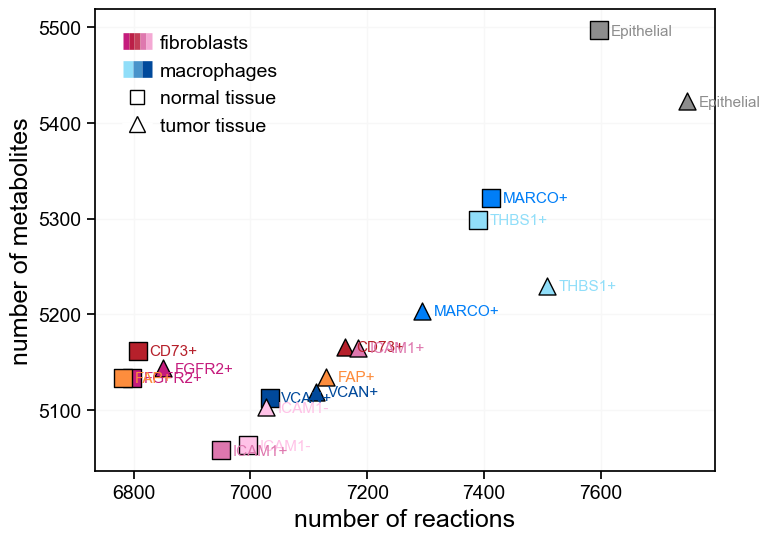

In [5]:
def plotModelSizesScatter(binary_rxns_df, binary_mets_df, binary_genes_df, marker_colors, figsize=(8, 6)):

    # Load data matrices
    binary_matrices = {
        'Reactions': binary_rxns_df.select_dtypes(include=['int64', 'float64']),
        'Metabolites': binary_mets_df.select_dtypes(include=['int64', 'float64']),
        'Genes': binary_genes_df.select_dtypes(include=['int64', 'float64'])
    }
    
    # Process all models
    model_data = []
    
    for model_id in binary_matrices['Reactions'].columns:
        label = model_id.split('_')[-1]
        if label in ['DES+', 'MFAP5+']:
            continue # skip myofibroblasts
            
        state = 'Tumor' if 'Tumor' in model_id else 'Normal'
        
        # Get sizes for each component
        sizes = {comp: matrix.get(model_id, pd.Series()).sum() 
                for comp, matrix in binary_matrices.items()}
        
        model_data.append({
            'label': label,
            'state': state,
            'reactions': sizes['Reactions'],
            'metabolites': sizes['Metabolites'],
            'marker': 's' if state == 'Normal' else '^',
            'priority': 1 if label in ['MARCO+', 'FAP+'] else 0
        })
    
    # Create DataFrame and sort
    model_df = pd.DataFrame(model_data).sort_values('priority')
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot points
    for _, row in model_df.iterrows():
        ax.scatter(row['reactions'], row['metabolites'],
                  color=marker_colors.get(row['label'], 'black'),
                  marker=row['marker'],
                  s=150,
                  edgecolors='black')
        
        # Add annotation
        if row['label'] == 'Malignant': row['label'] = 'Epithelial'
        ax.text(row['reactions'] + 20, row['metabolites'] - 5,
               row['label'],
               fontsize=11,
               alpha=1,
               color=marker_colors.get(row['label'], 'black'))
    
    # Create legend
    class GradientLine:
        pass

    # Create legend elements
    fib_line = GradientLine()
    mac_line = GradientLine()
    legend_elements = [
        fib_line,  # will be replaced by gradient
        mac_line,  # will be replaced by gradient
        Line2D([0], [0], marker='s', color='w', label='normal tissue',  markerfacecolor='white', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='^', color='w', label='tumor tissue',  markerfacecolor='white', markersize=12, markeredgecolor='black'),
    ]
    legend_labels = ['fibroblasts','macrophages', 'normal tissue', 'tumor tissue']
    
    # Get colors for gradients
    fib_colors = [marker_colors[m] for m in markers_F]
    mac_colors = [marker_colors[m] for m in markers_M]
    
    # Create handler map
    handler_map = { fib_line: GradientLineHandler(fib_colors, n_segments=len(fib_colors)+1),
                    mac_line: GradientLineHandler(mac_colors, n_segments=len(mac_colors)+1) }
    
    # Add legend to axis
    ax.legend(legend_elements, legend_labels,
                    handler_map=handler_map,
                    bbox_to_anchor=(0.02, 0.98),
                    loc='upper left',
                    frameon=False,
                    fontsize=14,
                    handletextpad=0.4,
                    borderpad=0.3,
                    handlelength=1.5,
                    alignment='left',
                    ncol=1)
    # Set axis labels
    ax.set_xlabel('number of reactions')
    ax.set_ylabel('number of metabolites')
    
    if resave_figures: save_figure(fig, 'figure1b_scatter_plot_gem_sizes')
    plt.show()
    
    return fig


fig1b = plotModelSizesScatter(DATA['binary_rxns'], DATA['binary_mets'], DATA['binary_genes'], marker_colors, figsize=(8, 6))

##### **(C)** PCA of binary gene, metabolite, and reaction vectors showing cell type clustering across all populations, fibroblast subtypes, and macrophage subtypes, confirming metabolic identity preservation regardless of tissue origin. 

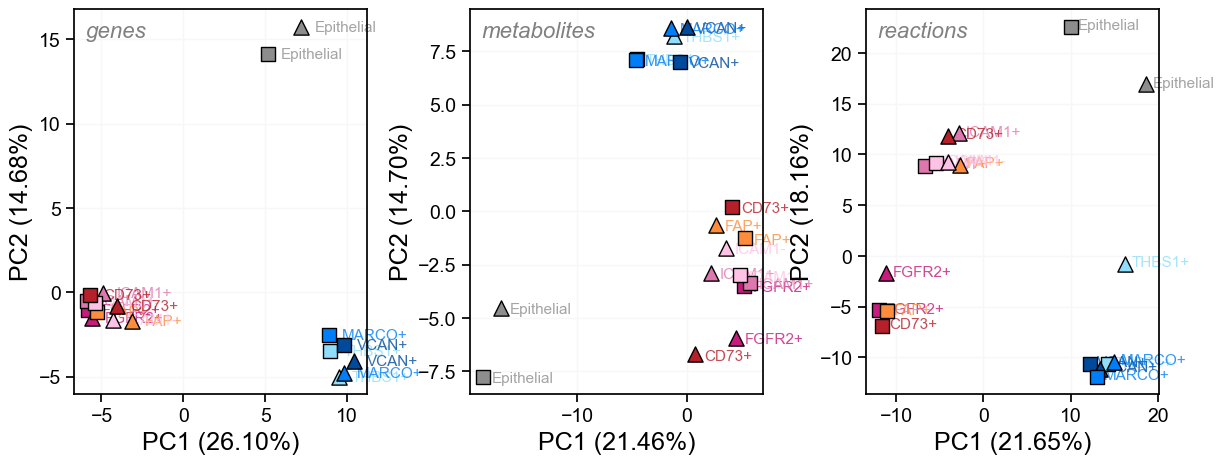

In [6]:
def plotStructuralPCA(binary_rxns_df, binary_mets_df, binary_genes_df, marker_colors, figsize=(16, 18), show_all=False):

    # Configuration
    cell_types = ['All Markers'] if not show_all else ['All Markers', 'Fibroblast', 'Macrophage'] 
    marker_map = {'Normal': 's', 'Tumor': '^'}
    
    # Load data into dict
    binary_matrices = {
        'Genes': binary_genes_df.select_dtypes(include=['int64', 'float64']),
        'Metabolites': binary_mets_df.select_dtypes(include=['int64', 'float64']),
        'Reactions': binary_rxns_df.select_dtypes(include=['int64', 'float64'])
    }
    
    # Create figure
    nrows = len(cell_types)
    fig, axes = plt.subplots(nrows, 3, figsize=(figsize[0], figsize[1] * nrows / 3))
    if nrows == 1:
        axes = axes.reshape(1, -1)  # Ensure 2D array for consistency
    
    # Process each cell type
    for row_idx, cell_type in enumerate(cell_types):
        # Filter matrices by cell type
        filtered_matrices = {}
        for name, matrix in binary_matrices.items():
            filtered_matrices[name] = (
                matrix if cell_type == 'All Markers' 
                else matrix.loc[:, matrix.columns.str.contains(cell_type)]
            )
        
        # Extract metadata
        model_ids = list(filtered_matrices['Reactions'].columns)
        model_states = ['Tumor' if 'Tumor' in mid else 'Normal' for mid in model_ids]
        
        # Create PCA plots for each matrix type
        for col_idx, (matrix_name, binary_matrix) in enumerate(filtered_matrices.items()):
            ax = axes[row_idx, col_idx]
            
            # Perform PCA
            pca = PCA(n_components=2)
            scores = pca.fit_transform(binary_matrix.T)
            explained = pca.explained_variance_ratio_ * 100
            
            # Plot each model
            for j, model_id in enumerate(model_ids):
                label = model_id.split('_')[-1]
                if label == 'Malignant': label = 'Epithelial' 
                if label in ['DES+', 'MFAP5+']: continue # Skip myofibroblasts
                    
                color = marker_colors.get(label, 'black') if marker_colors else 'black'
                marker = marker_map[model_states[j]]
                
                marker_size = 90 if marker == 's' else 120
                ax.text(scores[j, 0] + 0.8, scores[j, 1] - 0.25,  label, fontsize=11, alpha=.8, color=color, zorder=1)
                ax.scatter(scores[j, 0], scores[j, 1], color=color, marker=marker, s=marker_size, edgecolors='black', zorder=3)
            
            
            # Formatting
            ax.set_xlabel(f'PC1 ({explained[0]:.2f}%)')
            ax.set_ylabel(f'PC2 ({explained[1]:.2f}%)')
            

    
            # Add titles

            if show_all:
                if row_idx == 0:
                    ax.set_title(f'{matrix_name.lower()}')
                if col_idx == 0:
                    ax.text(-0.5, 0.5, cell_type, rotation=90, fontsize=18, transform=ax.transAxes, verticalalignment='center')
            else:
                label_text = matrix_name.lower() 
                ax.text(0.04, 0.97, label_text, transform=ax.transAxes,
                        fontsize=16, color='gray', fontstyle='italic',
                        ha='left', va='top')

    
    plt.subplots_adjust(wspace=.35)
    if resave_figures: save_figure(fig, 'figure1c_pca_genes_mets_rxns')
    plt.show()
    
    return fig

fig1c = plotStructuralPCA(DATA['binary_rxns'], DATA['binary_mets'], DATA['binary_genes'], marker_colors, figsize=(14, 15))


##### **(D)** Growth rate fold changes showing decreased biomass production in tumor-associated cells compared to normal counterparts. Dashed red line shows a ratio of 1, indicating the same growth rate for tumor and normal conditions.

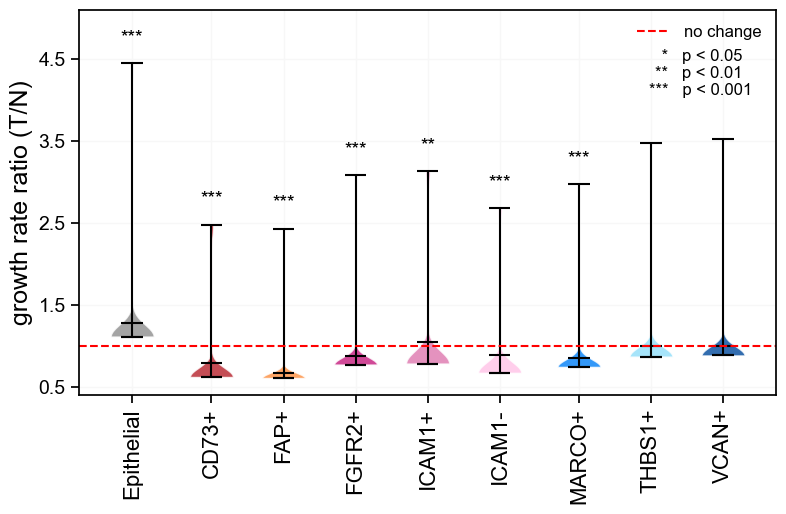

In [7]:
def plotRxnDistribution(samples_data, markers, marker_colors, target_reaction,  normalization='fold_change', hide_normal = True, figsize=(12, 8)):
    
    # Find reaction index
    reaction_idx = None
    reaction_name = None
    for model_name, model_data in samples_data.items():
        for idx, rxn_id in model_data['reactionIDs'].items():
            if rxn_id == target_reaction:
                reaction_idx = idx
                reaction_name = model_data['reactionNames'][idx]
                break
        if reaction_idx is not None:
            break
    
    if reaction_idx is None:
        raise ValueError(f"Reaction {target_reaction} not found in the data")
    
    # Collect data for each marker and condition
    plot_data = []
    
    for marker in markers:
        matching_models = []
        for model_name in samples_data.keys():
            if model_name.endswith(marker):
                matching_models.append(model_name)
        
        for model_name in matching_models:
            parts = model_name.split('_')
            
            if len(parts) >= 3:
                cell_type = parts[0]
                condition = parts[1]
                
                try:
                    flux_values = samples_data[model_name]['samples'].iloc[reaction_idx].values
                    
                    for value in flux_values:
                        plot_data.append({
                            'marker': marker,
                            'cell_type': cell_type,
                            'condition': condition,
                            'flux': value,
                            'model': model_name
                        })
                        
                except Exception as e:
                    continue
    
    if not plot_data:
        raise ValueError("No data found for the specified markers.")
    
    df = pd.DataFrame(plot_data)
    
    # Apply normalization 
    if normalization != 'none':
        df_normalized = df.copy()
        
        if normalization == 'fold_change':
            normalized_data = []
            
            for cell_type in df['cell_type'].unique():
                for marker in df['marker'].unique():
                    normal_data = df[(df['cell_type'] == cell_type) & 
                                   (df['marker'] == marker) & 
                                   (df['condition'] == 'Normal')]
                    
                    tumor_data = df[(df['cell_type'] == cell_type) & 
                                  (df['marker'] == marker) & 
                                  (df['condition'] == 'Tumor')]
                    
                    if len(normal_data) > 0 and len(tumor_data) > 0:
                        normal_mean = normal_data['flux'].mean()
                        
                        for _, row in tumor_data.iterrows():
                            if normal_mean != 0:
                                fold_change = row['flux'] / normal_mean
                            else:
                                fold_change = row['flux']
                            
                            normalized_data.append({
                                'marker': marker,
                                'cell_type': cell_type,
                                'condition': 'Tumor',
                                'flux': fold_change,
                                'model': row['model']
                            })
                    elif len(tumor_data) > 0:
                        for _, row in tumor_data.iterrows():
                            normalized_data.append({
                                'marker': marker,
                                'cell_type': cell_type,
                                'condition': 'Tumor',
                                'flux': row['flux'],
                                'model': row['model']
                            })
            
            df_normalized = pd.DataFrame(normalized_data)
            ylabel = f'growth rate ratio (T/N)'
            
        elif normalization == 'z_score':
            for cell_type in df['cell_type'].unique():
                for marker in df['marker'].unique():
                    mask = (df_normalized['cell_type'] == cell_type) & (df_normalized['marker'] == marker)
                    cell_marker_data = df_normalized[mask]['flux']
                    
                    if len(cell_marker_data) > 1:
                        z_scores = stats.zscore(cell_marker_data)
                        df_normalized.loc[mask, 'flux'] = z_scores
                    else:
                        df_normalized.loc[mask, 'flux'] = 0
            
            ylabel = f'z-Score\n({reaction_name})'
        
        df_plot = df_normalized
        
    else:
        df_plot = df
        ylabel = f'flux\n({reaction_name})'
    
    # Statistical significance testing
    significance_results = {}
    
    # Test if tumor values are significantly different from 1 (no change)
    # or from 0 (mean) for z-score normalization
    reference_value = 1.0 if normalization == 'fold_change' else 0.0
    
    for cell_type in df_plot['cell_type'].unique():
        for marker in df_plot['marker'].unique():
            tumor_data = df_plot[(df_plot['cell_type'] == cell_type) & 
                                (df_plot['marker'] == marker) & 
                                (df_plot['condition'] == 'Tumor')]['flux']
            
            if len(tumor_data) > 0:
                # One-sample t-test against reference value
                from scipy.stats import ttest_1samp
                try:
                    stat, p_value = ttest_1samp(tumor_data, reference_value)
                    significance_results[f"{cell_type}_{marker}"] = p_value
                except:
                    significance_results[f"{cell_type}_{marker}"] = None
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    cell_types = sorted(df_plot['cell_type'].unique())
    conditions = sorted(df_plot['condition'].unique())
    
    positions = {}
    x_pos = 0
    x_labels = []
    x_ticks = []
    
    for cell_type in cell_types:
        for condition in conditions:
            if hide_normal and condition == 'Normal':
                continue
                
            available_data = df_plot[(df_plot['cell_type'] == cell_type) &  (df_plot['condition'] == condition)]
            available_markers = sorted(available_data['marker'].unique())
            
            if len(available_markers) > 0:
                for marker in available_markers:
                    key = f"{cell_type}_{condition}_{marker}"
                    positions[key] = x_pos
                    
                    # Simplified labels without significance stars (stars will be shown above plots)
                    label = f"{marker}" if hide_normal else f"{marker}\n({condition})"
                    
                    x_labels.append(label)
                    x_ticks.append(x_pos)
                    x_pos += 1
                
                x_pos += 0.1
        
    
    # Plot based on plot_type
    for cell_type in cell_types:
        for condition in conditions:
            if hide_normal and condition == 'Normal':
                continue
                
            available_data = df_plot[(df_plot['cell_type'] == cell_type) & 
                                    (df_plot['condition'] == condition)]
            available_markers = sorted(available_data['marker'].unique())
            
            for marker in available_markers:
                marker_data = available_data[available_data['marker'] == marker]
                
                if len(marker_data) > 0:
                    key = f"{cell_type}_{condition}_{marker}"
                    pos = positions[key]
                    color = marker_colors.get(marker, 'gray')
                    parts = ax.violinplot([marker_data['flux'].values], 
                                        positions=[pos], widths=0.6, 
                                        showmeans=True, showmedians=True)
                    
                    for part in parts.values():
                        if hasattr(part, 'set_color'):
                            part.set_color('black')
                    
                    for pc in parts['bodies']:
                        pc.set_facecolor(color)
                        pc.set_alpha(.8)
                    
                    # Add significance stars above the violin plot
                    sig_key = f"{cell_type}_{marker}"
                    if sig_key in significance_results and significance_results[sig_key] is not None:
                        p_val = significance_results[sig_key]
                        data_max = marker_data['flux'].max()
                        y_pos = data_max + 0.2  # Position above the highest point
                        if p_val < 0.001: ax.text(pos, y_pos, '***', ha='center', va='bottom', fontsize=14)
                        elif p_val < 0.01: ax.text(pos, y_pos, '**', ha='center', va='bottom', fontsize=14)
                        elif p_val < 0.05: ax.text(pos, y_pos, '*', ha='center', va='bottom',  fontsize=14)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=90, ha='center', fontsize=16) # manual fontsize
    ax.set_yticks(np.arange(0.5, 5.4, 1))
    ax.set_ylabel(ylabel)

    markerlabels = ax.get_xticklabels()
    # Change markerlabels where Malignant to Epithelial
    for i, label in enumerate(markerlabels):
        if 'Malignant' in label.get_text():
            label.set_text(label.get_text().replace('Malignant', 'Epithelial'))
    ax.set_xticklabels(markerlabels)
    
    # Set y-axis limits
    ax.set_ylim(0.4, 5.1)
    
    # Add reference line and isgnificance legend
    ax.axhline(y=1, color='red', linestyle='--', alpha=1, label='no change')
    legend_text = " *   p < 0.05  \n**   p < 0.01  \n***   p < 0.001"
    ax.text(0.965, 0.9, legend_text, transform=ax.transAxes,
            ha='right', va='top', fontsize=12, color='black')
    # Add legend for reference line
    ax.legend(loc='upper right', fontsize=12, frameon=False)
        
    if resave_figures: save_figure(fig, 'figure1d_growth_rate_ratios')
    plt.show()
    
    return fig

biomass_reaction = "MAR13082"
fig1d = plotRxnDistribution(samples_data_corners, markers_all, marker_colors, biomass_reaction, figsize=(9, 5))

##### **(E)** Scatter plots of mean reaction fluxes comparing tumor versus normal conditions for fibroblasts and macrophages.

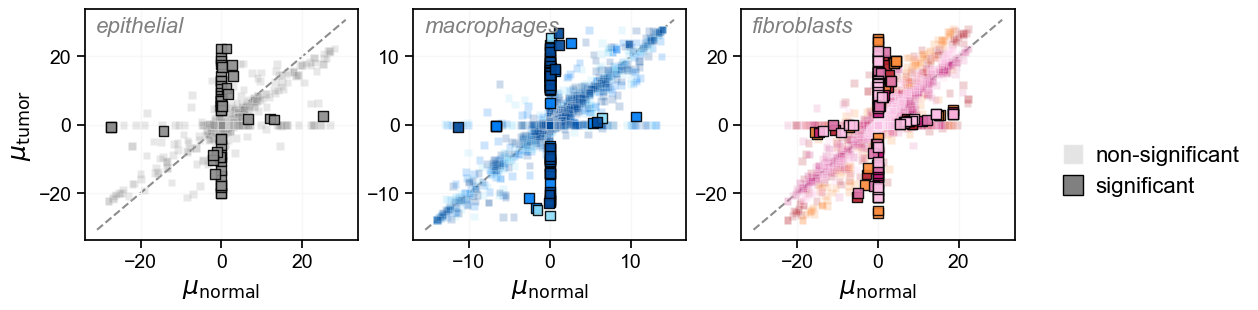

In [8]:
def plotSignificantScatter(statistical_results, markers, marker_colors=None, title='Marker Comparison',
                          figsize=(8, 6), non_sig_alpha=0.1, sig_alpha=0.9, add_diagonal=True,
                          save_path=None, ax=None):
    

    # Filter data for specified markers
    data = statistical_results[statistical_results['marker'].isin(markers)].copy()
    data = data[~data['subsystem'].str.contains('Transport', case=False)] # too many
    data = data[~data['subsystem'].str.contains('Exchange', case=False)] # too many
    data = data[~data['marker'].isin(['DES+', 'MFAP5+'])] # remove myofibroblasts

    # Create default colors
    if marker_colors is None:
        palette = sns.color_palette("husl", n_colors=len(markers))
        marker_colors = dict(zip(markers, palette))

    # Use provided ax or make one
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Non-significant
    sns.scatterplot(
        data=data, x='normal_mean', y='tumor_mean',
        hue='marker', palette=marker_colors,
        s=30, marker='s', alpha=non_sig_alpha,
        legend=False, ax=ax
    )

    # Significant
    sig_data = data[data['significant']].copy()
    sns.scatterplot(
        data=sig_data, x='normal_mean', y='tumor_mean',
        hue='marker', marker='s', palette=marker_colors,
        s=50, alpha=sig_alpha, edgecolor='black', linewidth=1, ax=ax, legend=False
    )

    # Diagonal
    if add_diagonal:
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
        ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)

    # Style
    ax.set_xlabel(r'$\mu_{\text{normal}}$')
    ax.set_ylabel(r'$\mu_{\text{tumor}}$')
    ax.set_facecolor('white')
    
    ax.text(0.04, 0.97, title.lower() , transform=ax.transAxes,
            fontsize=16, color='gray', fontstyle='italic',
            ha='left', va='top')

    return fig, ax

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot each scatter
plotSignificantScatter(statistical_results_TvsN, markers=['Malignant'],
                       marker_colors=marker_colors, title='Epithelial',
                       ax=axes[0], non_sig_alpha=0.2, sig_alpha=0.9)

plotSignificantScatter(statistical_results_TvsN, markers=markers_M,
                       marker_colors=marker_colors, title='Macrophages',
                       ax=axes[1], non_sig_alpha=0.2, sig_alpha=0.9)

plotSignificantScatter(statistical_results_TvsN, markers=markers_F,
                       marker_colors=marker_colors, title='Fibroblasts',
                       ax=axes[2], non_sig_alpha=0.2, sig_alpha=0.9)

# Hide y-axis labels and ticks for all but the first subplot
for ax in axes[1:]:
    ax.set_ylabel('')

# Add legends to last plot
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='non-significant', markerfacecolor='lightgray', markersize=15, alpha=0.6,markeredgecolor='white'),
    Line2D([0], [0], marker='s', color='w', label='significant', markerfacecolor='gray', markersize=15, markeredgecolor='black'),
]
axes[2].legend(handles=legend_elements, bbox_to_anchor=(1.1, 0.45), frameon=False, framealpha=1, edgecolor='black',fontsize=16, handletextpad=0, borderaxespad=0, alignment='left')
if resave_figures: save_figure(fig, 'figure1e_significance_scatters')
plt.show()
fig1e = fig
fig = None


##### **(F)** Quantification showing number of significantly differentially active reactions per cell type.

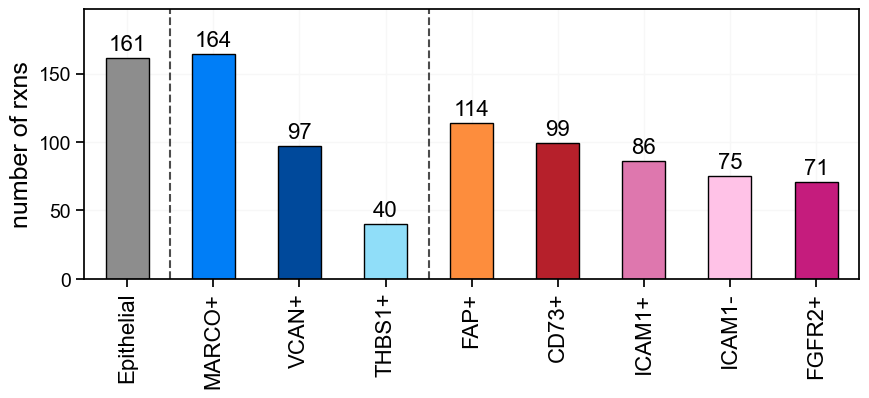

In [9]:
def plotSignificantReactionsBar(statistical_results_TvsN, marker_colors, figsize=(12, 6)):
 
    # Count significant reactions per marker
    sig_counts = statistical_results_TvsN[statistical_results_TvsN['significant'] == True].groupby('marker').size()
    
    # Group markers by cell type
    epithelial_markers = ['Malignant']
    fibroblast_markers = ['FAP+', 'FGFR2+', 'ICAM1+', 'ICAM1-', 'CD73+']
    macrophage_markers = ['MARCO+', 'THBS1+', 'VCAN+']
    
    # Sort within each group by count (descending)
    fib_sorted = sorted([m for m in fibroblast_markers if m in sig_counts.index], 
                       key=lambda x: sig_counts[x], reverse=True)
    mac_sorted = sorted([m for m in macrophage_markers if m in sig_counts.index], 
                       key=lambda x: sig_counts[x], reverse=True)
    epi_sorted = [m for m in epithelial_markers if m in sig_counts.index]
    
    # Combine all markers
    all_markers = epi_sorted + mac_sorted + fib_sorted
    all_counts = [sig_counts.get(m, 0) for m in all_markers]
    all_colors = [marker_colors.get(m, 'gray') for m in all_markers]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    plt.grid(True)
    
    # Create bars
    bars = ax.bar(range(len(all_markers)), all_counts, color=all_colors, alpha=1, width=0.5, edgecolor='black', linewidth=1)
    
    # Add value labels on top of bars
    for i, count in enumerate(all_counts):
        ax.text(i, count + max(all_counts)*0.01 + 1, str(count), 
               ha='center', va='bottom', fontsize=16)
    
    # Change all_markers where 'Malignant' to 'Epithelial'
    all_markers = ['Epithelial' if m == 'Malignant' else m for m in all_markers]
    # Customize plot
    ax.set_xticks(range(len(all_markers)))
    ax.set_xticklabels(all_markers, fontsize=16, rotation=90, ha='center')
    ax.set_ylabel('number of rxns')
    ax.set_xlim(-0.5, len(all_markers)-0.5)
    
    # Add group separators and labels
    if len(epi_sorted) > 0:
        ax.axvline(x=len(epi_sorted)-0.5, color='black', linestyle='--', alpha=0.7)
    if len(mac_sorted) > 0:
        ax.axvline(x=len(mac_sorted)+0.5, color='black', linestyle='--', alpha=0.7)
       ## ax.text(len(fib_sorted) + len(mac_sorted) + len(epi_sorted)/2 - 0.5, 170, 'epithelial', ha='center', fontsize=14)
    
    # Set y-axis to start from 0
    ax.set_ylim(0, max(all_counts)*1.2)

    plt.show()
    if resave_figures: save_figure(fig, 'figure1f_bars_differential_counts')

    
    return fig

# Create the bar plot
fig1f = plotSignificantReactionsBar(statistical_results_TvsN, marker_colors, figsize=(10, 3.5))

##### **(G)** Pathway-level distribution of differentially active reactions across metabolic subsystems for each cell type.

<>:133: SyntaxWarning: invalid escape sequence '\m'
<>:133: SyntaxWarning: invalid escape sequence '\m'
/var/folders/zn/vww37q7j5v178z8qs7cxyz3w0000gp/T/ipykernel_18642/2390814946.py:133: SyntaxWarning: invalid escape sequence '\m'
  ax_center.set_xlabel("higher $\mu_{\\text{flux}}$", fontsize=18, labelpad=20)


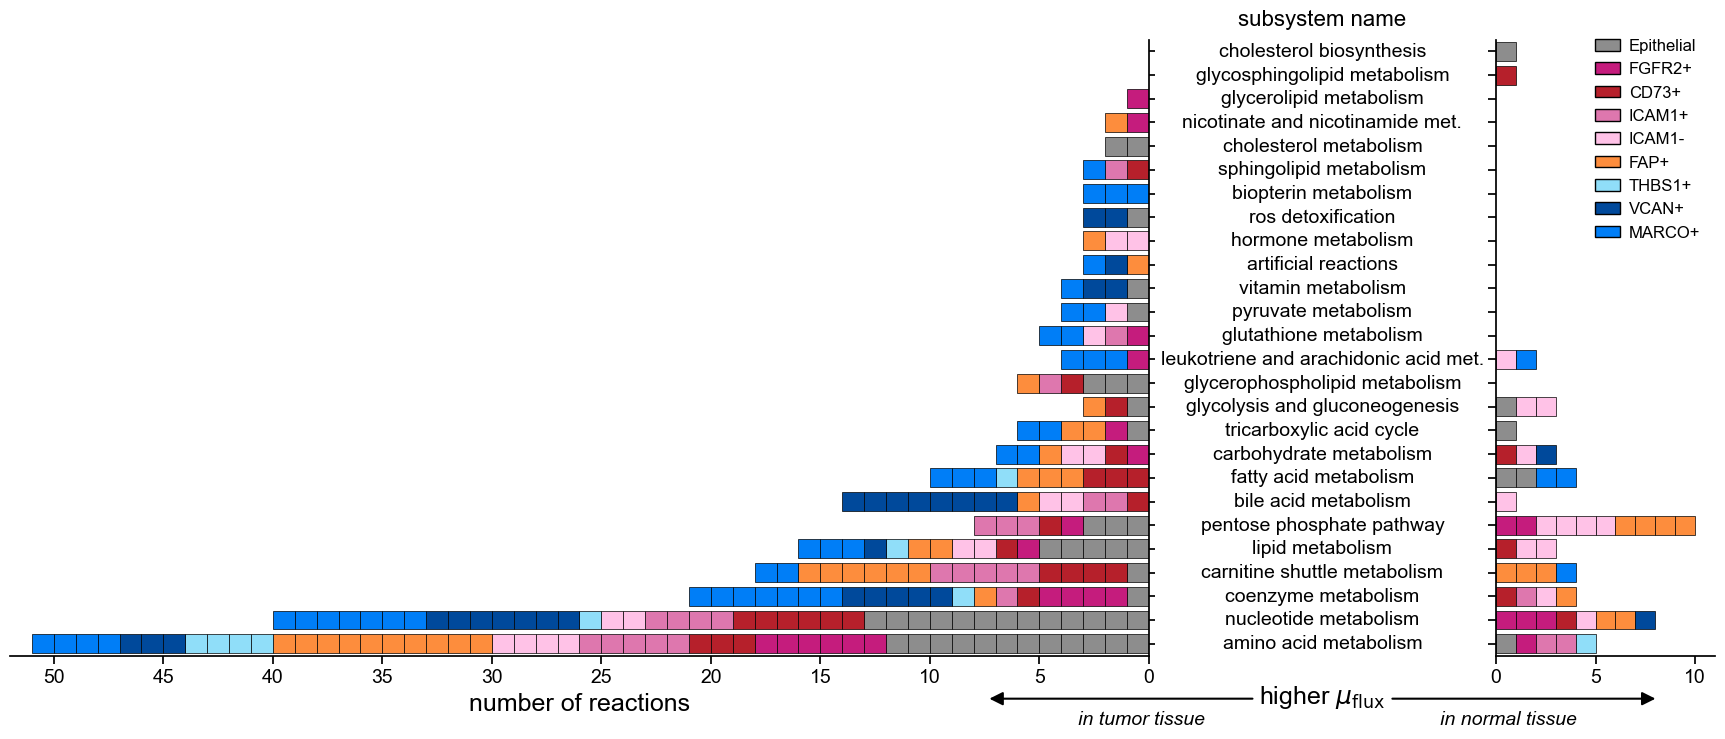

In [10]:
def plotMarkerStackedSubsystems(analysis_results, markers, marker_colors, title='', min_reactions=1, figsize=(16, 10)):  
    # Filter for significant reactions
    filtered_data = analysis_results[analysis_results['significant']]

    # Filter out transport reactions
    filtered_data = filtered_data[~filtered_data['subsystem'].str.contains('Transport', case=False)]
    filtered_data = filtered_data[~filtered_data['subsystem'].str.contains('Exchange', case=False)]
    filtered_data = filtered_data[~filtered_data['subsystem'].str.contains('other reactions', case=False)]
    
    if filtered_data.empty:
        print("No significant reactions found.")
        return
        
    # Count reactions by subsystem, marker, and direction
    subsystem_counts = defaultdict(lambda: defaultdict(lambda: {'up': 0, 'down': 0}))
    for _, row in filtered_data.iterrows():
        if row['marker'] in markers:
            subsystem_counts[row['subsystem']][row['marker']][row['direction']] += 1
    
    # Convert to plotting format
    plot_data = []
    for subsystem, marker_data in subsystem_counts.items():
        total_reactions = sum(sum(counts.values()) for counts in marker_data.values())
        
        if total_reactions >= min_reactions:
            subsystem_row = {
                'Subsystem': subsystem,
                'Total': total_reactions
            }
            
            for marker in markers:
                if marker in marker_data:
                    subsystem_row[f'{marker}_up'] = marker_data[marker]['up']
                    subsystem_row[f'{marker}_down'] = marker_data[marker]['down']
                else:
                    subsystem_row[f'{marker}_up'] = 0
                    subsystem_row[f'{marker}_down'] = 0
            
            plot_data.append(subsystem_row)
    
    if not plot_data:
        print(f"No subsystems with >= {min_reactions} reactions found.")
        return
        
    # Convert to DataFrame and sort
    plot_df = pd.DataFrame(plot_data)
    plot_df = plot_df.sort_values('Total', ascending=False)
    
    # Create figure with three subplots: left bars, center labels, right bars
    fig = plt.figure(figsize=figsize)
    
    # Define the grid layout with specific width ratios
    gs = fig.add_gridspec(1, 3, width_ratios=[0.78, 0.23, 0.15], wspace=0.01)
    
    ax_left = fig.add_subplot(gs[0])
    ax_center = fig.add_subplot(gs[1], sharey=ax_left)
    ax_right = fig.add_subplot(gs[2], sharey=ax_left)
    
    # Plot setup
    y_pos = np.arange(len(plot_df))
    
    # LEFT SUBPLOT - Upregulated (negative values shown as positive)
    left_pos = np.zeros(len(plot_df))
    
    for marker in markers:
        color = marker_colors.get(marker, "#808080")
        
        # Upregulated - goes to the LEFT subplot
        # Each bar is exactly 1 unit width
        up_values = plot_df[f'{marker}_up']
        if up_values.sum() > 0:
            for i, value in enumerate(up_values):
                if value > 0:
                    # Add individual squares for each count with black border
                    for j in range(int(value)):
                        ax_left.barh(y_pos[i], 1, left=left_pos[i] + j,  # Each bar is 1 unit wide
                               edgecolor='black', linewidth=0.5, 
                               color=color, height=0.8)
                    left_pos[i] += value
    
    # RIGHT SUBPLOT - Downregulated
    right_pos = np.zeros(len(plot_df))
    
    for marker in markers:
        color = marker_colors.get(marker, "#808080")
        
        # Downregulated - goes to the RIGHT subplot  
        # Each bar is exactly 1 unit width
        down_values = plot_df[f'{marker}_down']
        if down_values.sum() > 0:
            for i, value in enumerate(down_values):
                if value > 0:
                    for j in range(int(value)):
                        ax_right.barh(y_pos[i], 1, left=right_pos[i] + j,  # Each bar is 1 unit wide
                               edgecolor='black', linewidth=0.5,
                               color=color, height=0.8)
                    right_pos[i] += value
    
    # Determine the maximum range to use for both sides (same scale)
    max_left = left_pos.max() if left_pos.max() > 0 else 5
    max_right = right_pos.max() if right_pos.max() > 0 else 5
    max_range = max(max_left, max_right, 10) + 1  # Use the larger of the two + buffer
    
    # Customize LEFT subplot
    ax_left.set_yticks(y_pos)
    ax_left.set_yticklabels([])
    ax_left.tick_params(right=True, bottom=True, left=False, top=False)
    ax_left.invert_xaxis()  # Invert x-axis so bars grow from right to left
    
    # Set x-limits and ticks for left subplot (same scale as right)
    ax_left.set_xlim(max_range, 0)
    ax_left.set_xlabel("number of reactions")
    
    # Set x-ticks at intervals of 5
    left_ticks = np.arange(0, max_range + 1, 5)
    ax_left.set_xticks(left_ticks)
    ax_left.set_xticklabels([str(int(x)) for x in left_ticks])
    
    # Remove spines
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['left'].set_visible(False)
    ax_left.grid(False)
    
    # CENTER - Labels
    for spine in ax_center.spines.values():
        spine.set_visible(False)
    ax_center.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax_center.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax_center.set_xlim(0, 1)
    ax_center.set_ylim(-0.5, len(plot_df) - 0.5)
    ax_center.set_title('subsystem name', fontsize=16, pad=10)
    ax_center.grid(False)
    ax_center.set_xlabel("higher $\mu_{\\text{flux}}$", fontsize=18, labelpad=20)
    ax_center.text(0.15, -0.09, "in tumor tissue", transform=ax_center.transAxes,  ha='right', va='top', fontsize=14, color='black', fontstyle='italic')
    ax_center.text(0.85, -0.09, "in normal tissue", transform=ax_center.transAxes, ha='left', va='top', fontsize=14, color='black', fontstyle='italic')

    # Arrow vertical position (above the text)
    arrow_y = -0.07
    ax_center.annotate('', xy=(-0.5, arrow_y), xytext=(0.3, arrow_y),xycoords='axes fraction', arrowprops=dict(arrowstyle='-|>', lw=1.5, color='black', mutation_scale=20 ))
    ax_center.annotate('', xy=(1.5, arrow_y), xytext=(0.7, arrow_y),xycoords='axes fraction', arrowprops=dict(arrowstyle='-|>', lw=1.5, color='black', mutation_scale=20 ))

    # Add subsystem labels in the center
    for i, label in enumerate(plot_df['Subsystem']):
        if label == 'leukotriene and arachidonic acid metabolism': label = 'leukotriene and arachidonic acid met.'
        if label == 'nicotinate and nicotinamide metabolism': label = 'nicotinate and nicotinamide met.'
        ax_center.text(0.5, i, label, ha='center', va='center', fontsize=14)
    
    # RIGHT SUBPLOT - Downregulated
    ax_right.set_yticks(y_pos)
    ax_right.set_yticklabels([])
    
    # Set x-ticks at intervals of 5
    right_ticks = np.arange(0, max_range + 1, 5)
    ax_right.set_xticks(right_ticks)
    ax_right.set_xticklabels([str(int(x)) for x in right_ticks])
    ax_right.set_xlabel('')
    ax_right.set_xlim(0, 11)
    ax_right.grid(False)
    
    # Remove spines
    ax_right.spines['top'].set_visible(False)
    ax_right.spines['right'].set_visible(False)
    
    # Hide y-axis ticks on right subplot
    ax_right.tick_params(left=True, bottom=True, right=False, top=False)
    
    # Create legend at the bottom in one row
    legend_elements = []
    
    # Add marker legend entries
    for marker in markers:
        if marker == 'Malignant': marker = 'Epithelial'
        legend_elements.append(Rectangle((0, 0), 1, 1,
                                     facecolor=marker_colors.get(marker, "#808080"),
                                     edgecolor='black',
                                     linewidth=1,
                                     label=marker))
    
    # Add legend at the bottom of the figure in one row
    fig.legend(handles=legend_elements,
               bbox_to_anchor=(0.9, 0.9),
               ncol=1,  # All markers in one row
               frameon=False,
               fancybox=False,
               shadow=False,
               fontsize=12,
               edgecolor='black',
               facecolor='white',
               columnspacing=1.2,
               handlelength=1.5,
               handletextpad=0.5)
    
    
    if resave_figures: save_figure(fig, 'figure1g_subsystem_distribution')
    plt.show()
    return fig


# Usage example:
fig1g = plotMarkerStackedSubsystems(
    analysis_results=statistical_results_TvsN,
    markers=markers_all,
    marker_colors=marker_colors,
    min_reactions=0,
    figsize=(22, 8)
)


## Figure 1: Context-specific metabolic models reveal metabolic reprogramming in fibroblasts and macrophages in the tumor microenvironment.

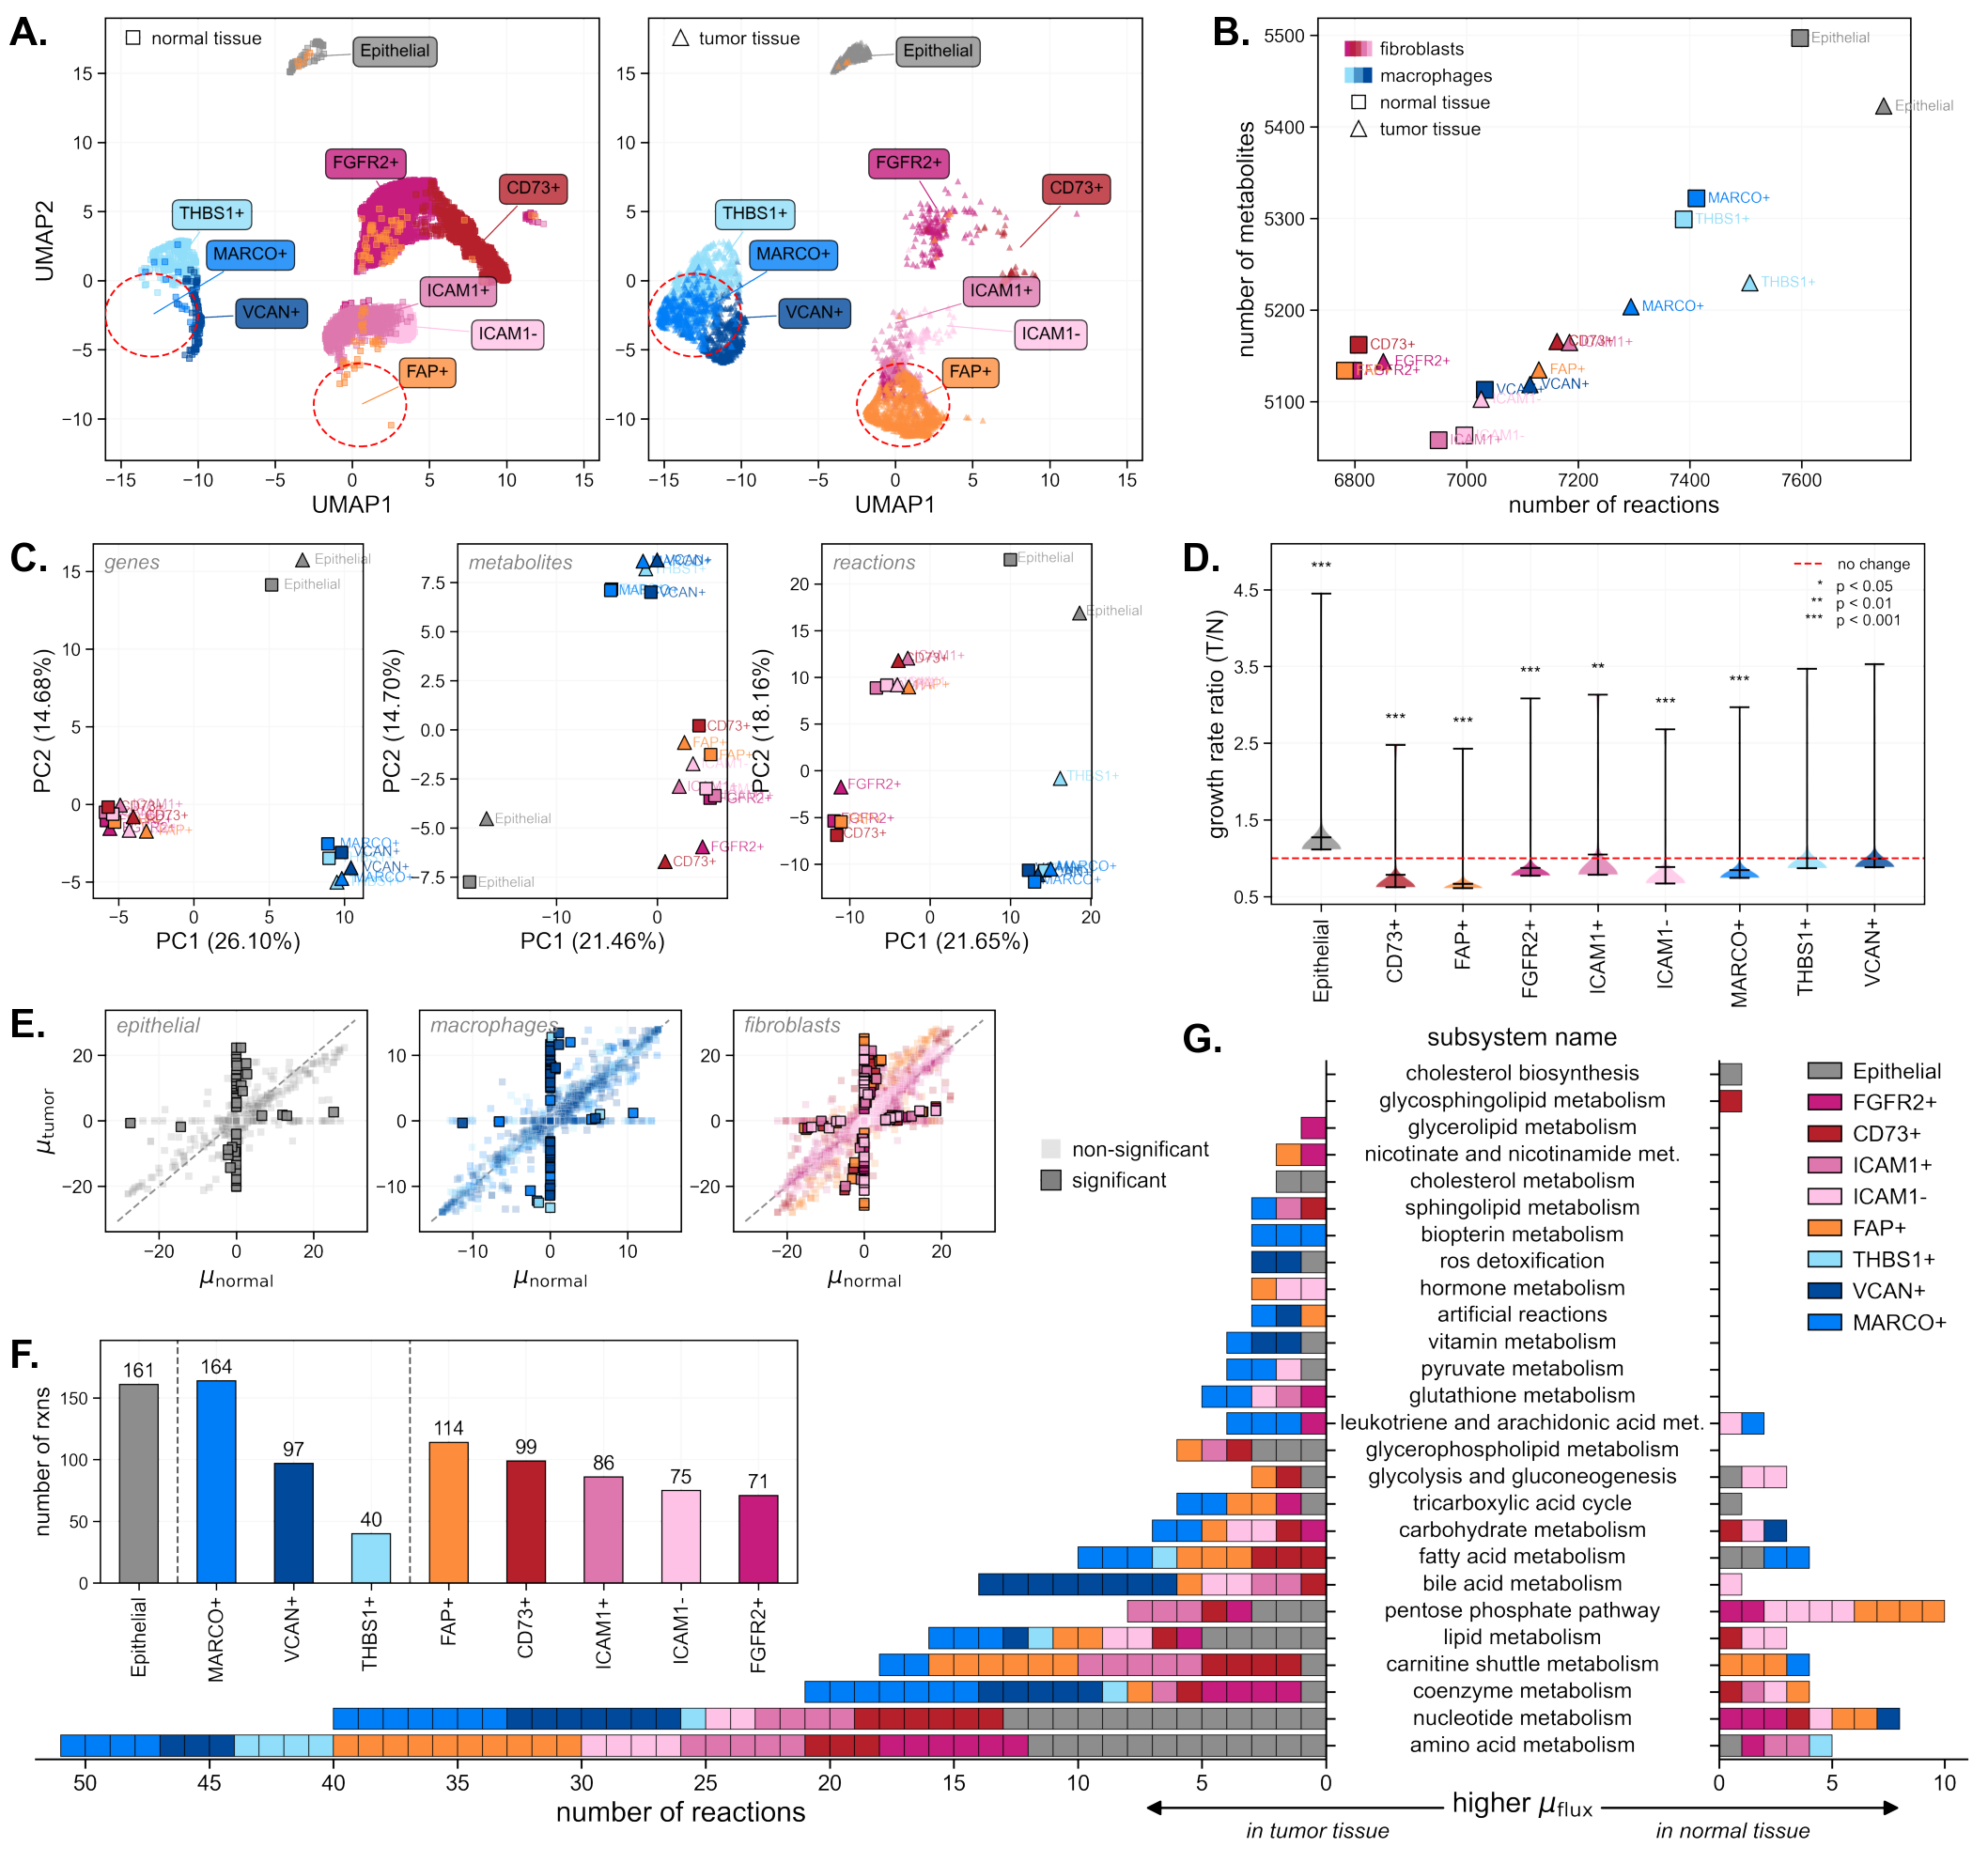

In [11]:
fig = plt.figure(figsize=(16, 16))
def add_panel(image_path, xyw, label=None, z=1):
    x, y, w = xyw
    # Read image to get aspect ratio
    img = mpimg.imread(image_path)
    img_h, img_w = img.shape[:2]
    aspect_ratio = img_h / img_w
    h = w * aspect_ratio  # scale height to keep image ratio
    bottom = 1 - y - h # Convert y from top-left origin to bottom-left origin
    ax = fig.add_axes([x, bottom, w, h], zorder=z)
    ax.imshow(img)
    ax.axis("off")
    if label:
        if label == "G": x=0.78
        fig.text(x-0.01, bottom + h -0.005, label +'. ', fontsize=30, ha='left', va='top', fontweight='bold')


add_panel("../figures/png/figure1a_single_cell_umap.png",         [0, 0, 0.75], "A")
add_panel("../figures/png/figure1b_scatter_plot_gem_sizes.png",   [0.8, 0, 0.49], "B")
add_panel("../figures/png/figure1c_pca_genes_mets_rxns.png",      [0, 0.35, 0.75], "C")
add_panel("../figures/png/figure1d_growth_rate_ratios.png",       [0.78, 0.35, 0.49], "D")
add_panel("../figures/png/figure1g_subsystem_distribution.png",   [0, 0.67, 1.3], "G", z=0) 
add_panel("../figures/png/figure1e_significance_scatters.png",    [0, 0.66, 0.8], "E", z=1)
add_panel("../figures/png/figure1f_bars_differential_counts.png", [0, 0.88, 0.52], "F", z=2)


if resave_figures: save_figure(fig, 'Figure1_GEMs_Sampling')

## Supp. F1: Hierarchical clustering of binary reaction vectors demonstrating separation between fibroblastand macrophage lineages by metabolic architecture.

Figure saved: SuppFig1_Hierarchical_Clustering


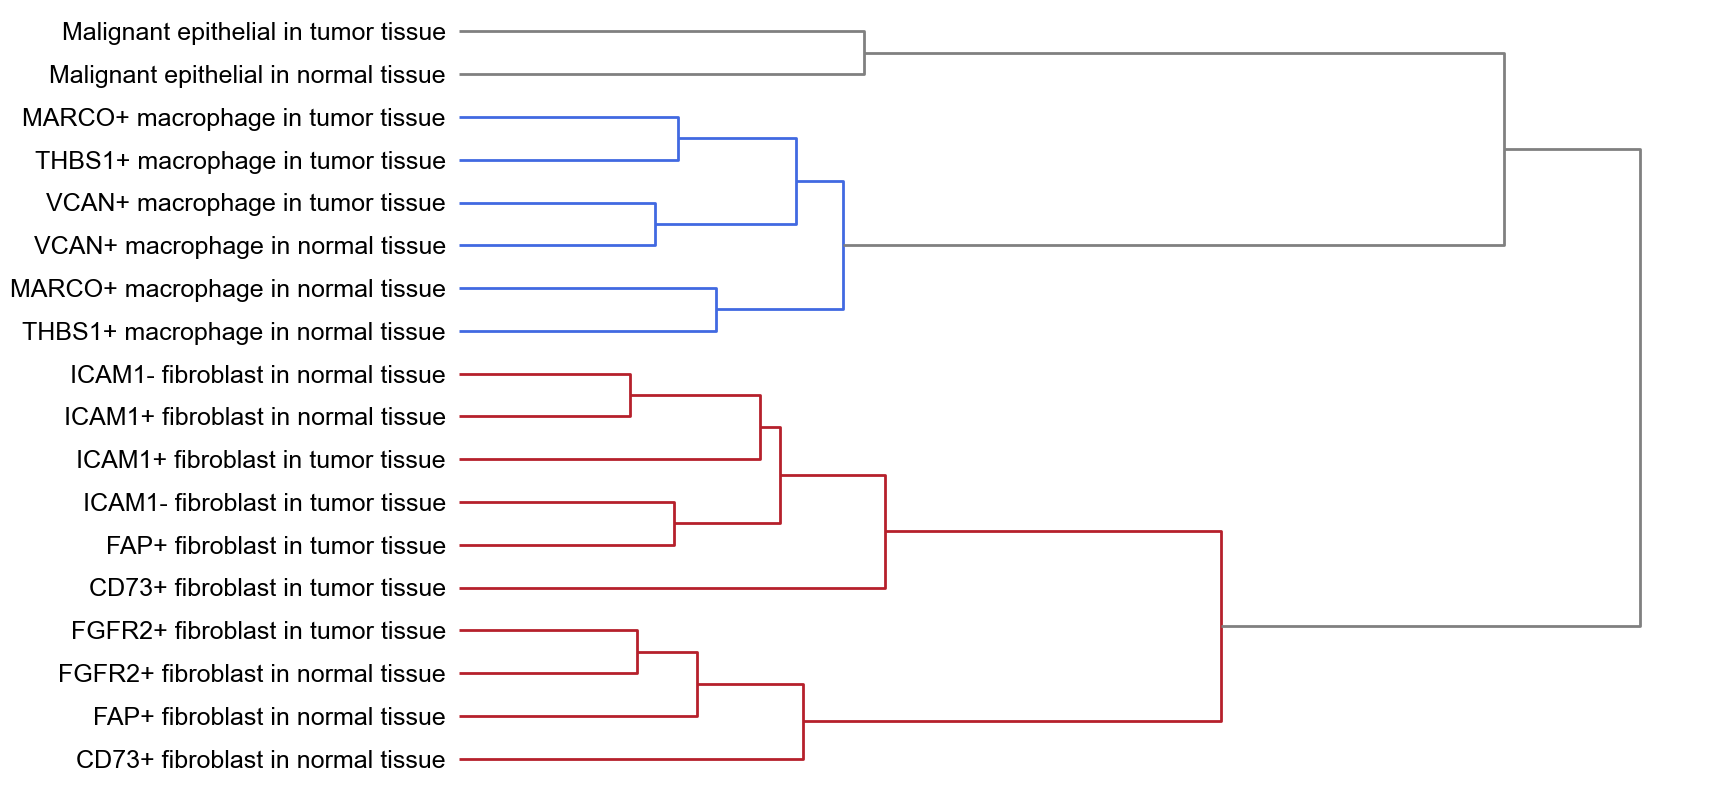

In [115]:
def plotHierarchicalClustering(binary_rxns_df, marker_colors, figsize=(12, 10),
                              clustering_method='ward', distance_metric='jaccard'):
    # Set the color palette for dendrogram branches
    set_link_color_palette(["#b6202b", 'royalblue', 'gray', 'black'])
    
    # Get numeric data and transpose (samples as rows, reactions as columns)
    binary_matrix = binary_rxns_df.select_dtypes(include=['int64', 'float64'])
    data_transposed = binary_matrix.T
    
    # Extract sample information from column names
    sample_names = data_transposed.index.tolist()
    
    # Parse the column names to extract cell type, condition, and marker
    parsed_samples = []
    for name in sample_names:
        parts = name.split('_')
        if len(parts) >= 3:
            cell_type = parts[0].lower()  # Fibroblast, Macrophage, etc.
            # Make cell_type epithelial if it is cancer
            if 'cancer' in cell_type:
                cell_type = 'epithelial'

            condition = parts[1].lower()  # Normal, Tumor
            marker = parts[2]  # FAP+, MARCO+, etc.
            parsed_samples.append((cell_type, condition, marker))
        else:
            # Handle cases like 'Cancer_Normal_Malignant'
            parsed_samples.append(('epithelial', parts[1].lower() if len(parts) > 1 else 'unknown', parts[-1]))
    
    # Create labels and states
    sample_labels = [marker for _, _, marker in parsed_samples]
    sample_states = ['Tumor' if condition == 'tumor' else 'Normal' for _, condition, _ in parsed_samples]
    cell_types = [cell_type for cell_type, _, _ in parsed_samples]
    
    # Filter out excluded samples
    excludemarkers = ['DES+', 'MFAP5+']
    mask = [label not in excludemarkers for label in sample_labels]
    filtered_data = data_transposed[mask]
    filtered_labels = [label for label, keep in zip(sample_labels, mask) if keep]
    filtered_states = [state for state, keep in zip(sample_states, mask) if keep]
    filtered_celltypes = [celltype for celltype, keep in zip(cell_types, mask) if keep]
    
    # Perform hierarchical clustering
    if distance_metric == 'jaccard':
        # For binary data, Jaccard distance might be more appropriate
        distances = pdist(filtered_data, metric='jaccard')
    else:
        distances = pdist(filtered_data, metric=distance_metric)
    
    linkage_matrix = linkage(distances, method=clustering_method)
    
    # Create dendrogram with modified labels including cell type and condition
    fig, ax_dendro = plt.subplots(figsize=figsize)
    
    dendro_labels = []
    for i, (label, state, celltype) in enumerate(zip(filtered_labels, filtered_states, filtered_celltypes)):
        suffix = 'in tumor tissue' if state == 'Tumor' else 'in normal tissue'
        dendro_labels.append(f"{label} {celltype} {suffix}")
    
    dendrogram(linkage_matrix, ax=ax_dendro, orientation='right',
                        labels=dendro_labels, leaf_rotation=0, leaf_font_size=18,
                        color_threshold=0.7*max(linkage_matrix[:,2]),  
                        above_threshold_color='gray', ) 
    
    plt.setp(ax_dendro.collections, linewidth=2)
    
    plt.grid(False)
    plt.box(False)
    plt.xticks([])

    
    if resave_figures: save_figure(fig, 'SuppFig1_Hierarchical_Clustering')
    
    plt.show()
    
    return fig

# Usage
suppf1 = plotHierarchicalClustering(DATA['binary_rxns'], marker_colors, figsize=(16, 10))

## Supp. F2: Hierarchical clustering of binary reaction vectors demonstrating separation between fibroblastand macrophage lineages by metabolic architecture.

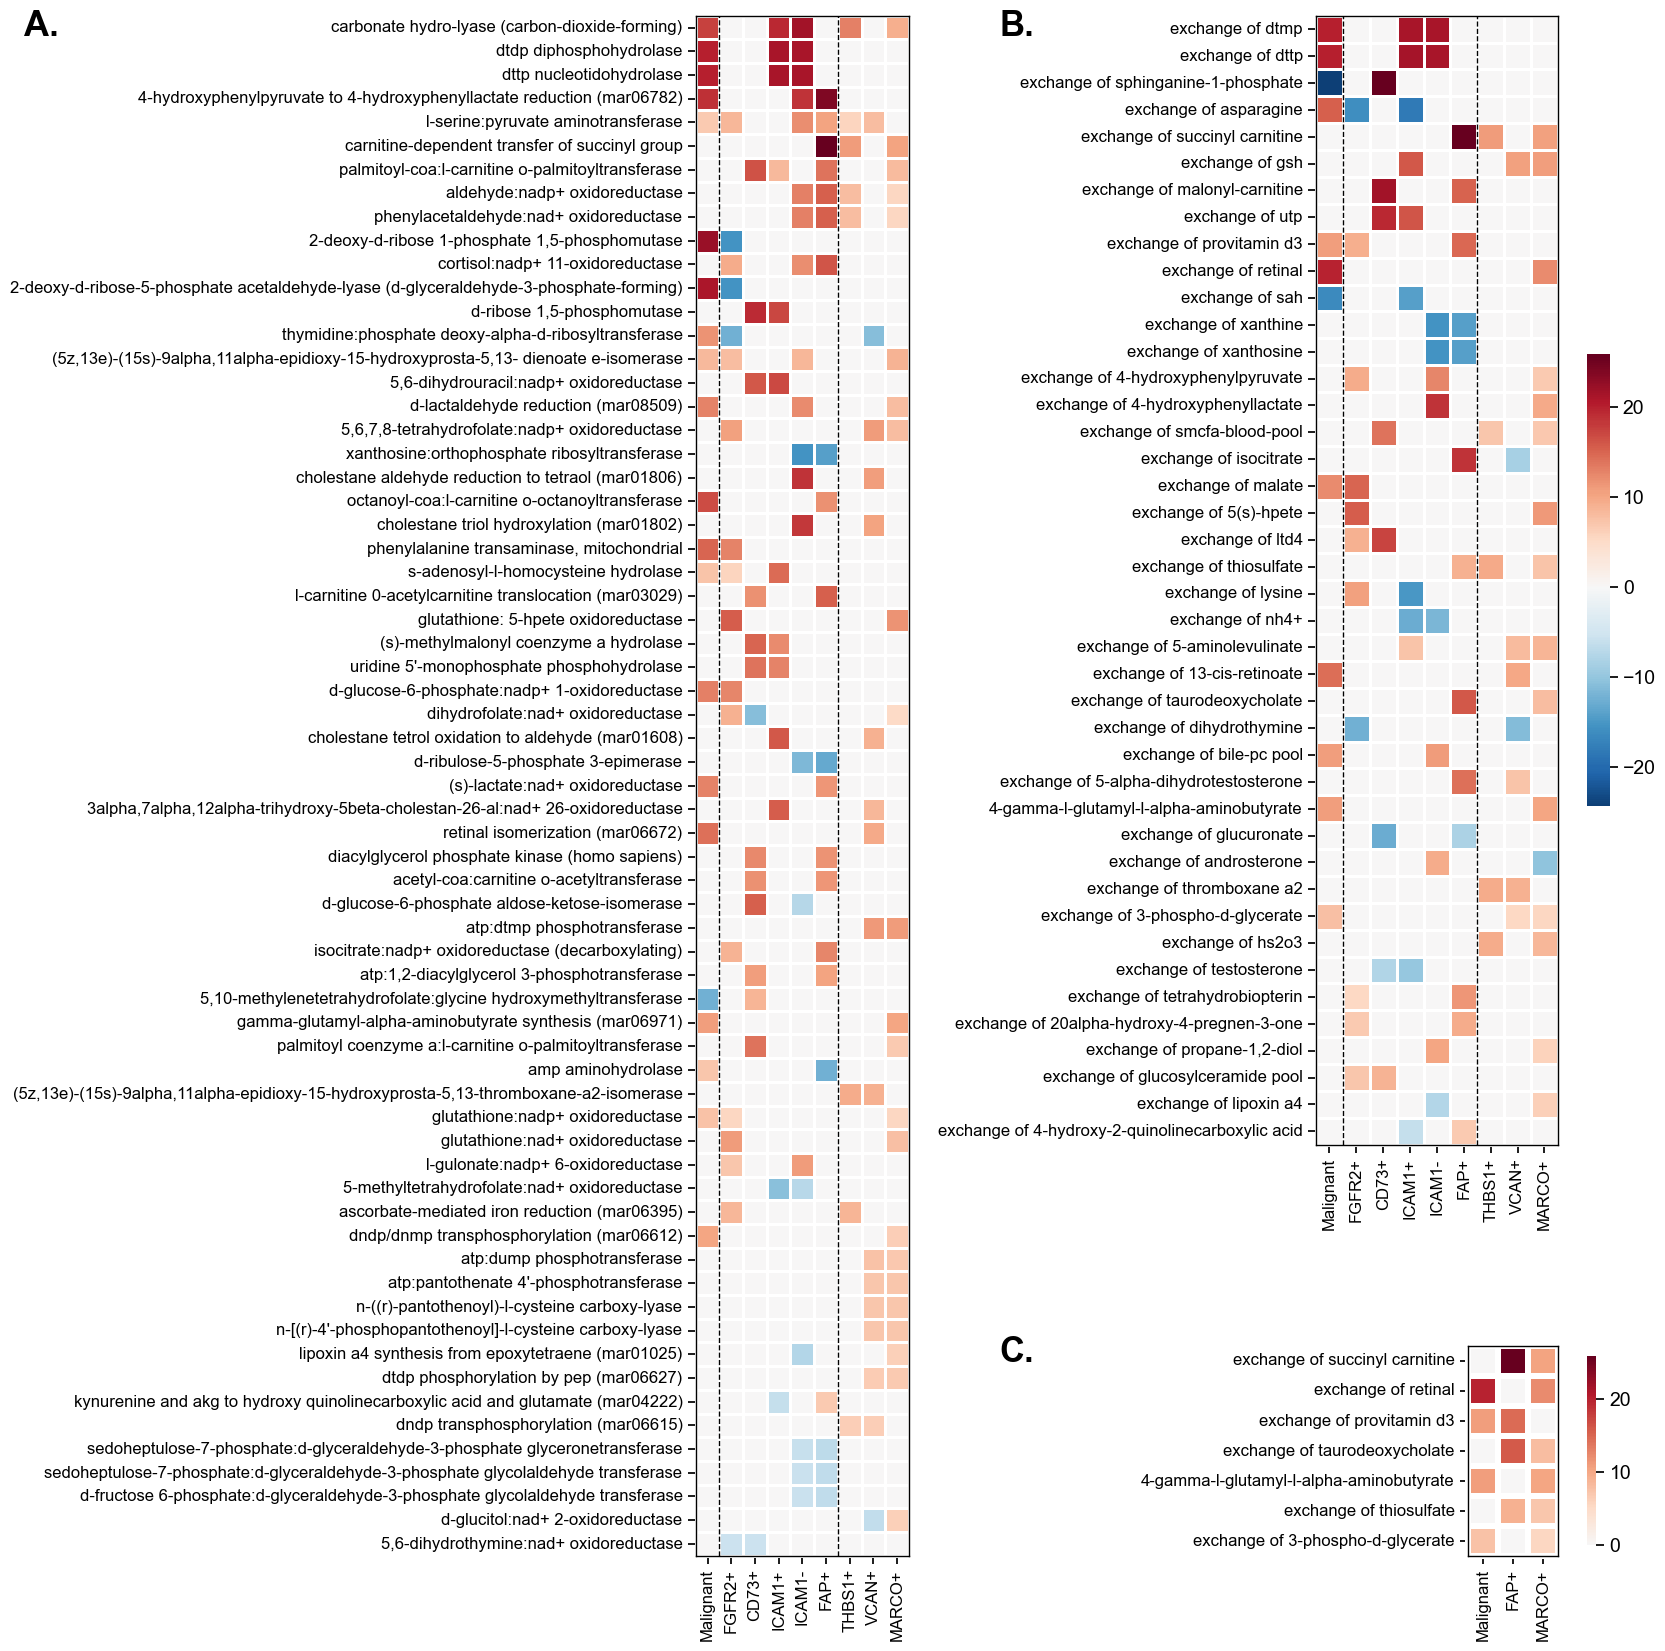

Figure saved: SuppFig2_Reaction_Level


In [114]:
def plotCombinedReactionMarkerHeatmap(analysis_results, markers, top_n=20, figsize=(18, 12), 
                                      colormap='RdBu_r', min_n_markers=3, min_n_markers_specific=1):

    filtered_data_regular = analysis_results[analysis_results['significant']].copy()
    filtered_data_regular = filtered_data_regular[
        ~filtered_data_regular['subsystem'].str.contains('Transport|Exchange', case=False)
    ]
    filtered_data_regular = filtered_data_regular[filtered_data_regular['marker'].isin(markers)]
    
    def truncate_reaction_name(name):
        fixes = {
            'MAR06782': '4-hydroxyphenylpyruvate to 4-hydroxyphenyllactate reduction (MAR06782)',
            'MAR03860': 'l-2-amino-3-oxobutanoic acid decarboxylation (MAR03860)',
            'MAR08509': 'd-lactaldehyde reduction (MAR08509)',
            'MAR06615': 'dNDP transphosphorylation (MAR06615)',
            'MAR06612': 'dNDP/dNMP transphosphorylation (MAR06612)',
            'MAR06627': 'dTDP phosphorylation by PEP (MAR06627)',
            'MAR06971': 'gamma-glutamyl-alpha-aminobutyrate synthesis (MAR06971)',
            'MAR01025': 'lipoxin A4 synthesis from epoxytetraene (MAR01025)',
            'MAR03029': 'l-carnitine 0-acetylcarnitine translocation (MAR03029)',
            'MAR01608': 'cholestane tetrol oxidation to aldehyde (MAR01608)',
            'MAR01802': 'cholestane triol hydroxylation (MAR01802)',
            'MAR01806': 'cholestane aldehyde reduction to tetraol (MAR01806)',
            'MAR06395': 'ascorbate-mediated iron reduction (MAR06395)',
            'MAR06672': 'retinal isomerization (MAR06672)',
            'MAR04222': 'kynurenine and akg to hydroxy quinolinecarboxylic acid and glutamate (MAR04222)',
            'Succ->C4Dcc': 'carnitine-dependent transfer of succinyl group'
        }
        if len(name) > 100 and name.rfind("(") != -1:
            return name[:name.rfind("(")].strip()
        return fixes.get(name, name)
    
    filtered_data_regular['display_name'] = filtered_data_regular['reaction_name'].apply(truncate_reaction_name).str.lower()
    
    filtered_data_exchange = analysis_results[analysis_results['significant']].copy()
    filtered_data_exchange = filtered_data_exchange[
        filtered_data_exchange['subsystem'].str.contains('exchange', case=False, na=False)
    ]
    filtered_data_exchange = filtered_data_exchange[filtered_data_exchange['marker'].isin(markers)]
    
    specific_markers = ['Malignant', 'FAP+', 'MARCO+']
    filtered_data_specific = analysis_results[analysis_results['significant']].copy()
    filtered_data_specific = filtered_data_specific[
        filtered_data_specific['subsystem'].str.contains('exchange', case=False, na=False)
    ]
    filtered_data_specific = filtered_data_specific[filtered_data_specific['marker'].isin(specific_markers)]
    
    def truncate_exchange_name(name):
        fixes = {
            'sink_CE1661[c]': '4-gamma-L-glutamyl-L-alpha-aminobutyrate',
            'DM_hs2o3[c]': 'exchange of hs2o3'
        }
        return fixes.get(name, name).lower()
    
    filtered_data_exchange['display_name'] = filtered_data_exchange['reaction_name'].apply(truncate_exchange_name)
    filtered_data_specific['display_name'] = filtered_data_specific['reaction_name'].apply(truncate_exchange_name)
    
    def create_pivot_data(filtered_data, marker_list, min_markers, top_n):
        filtered_data['signed_dist'] = filtered_data.apply(
            lambda x: x['wasserstein_dist'] if x['direction'] == 'up' else -x['wasserstein_dist'], axis=1
        )
        pvt = pd.pivot_table(
            filtered_data,
            values='signed_dist',
            index='display_name',
            columns='marker',
            fill_value=0
        )
        cols = [m for m in marker_list if m in pvt.columns]
        if cols:
            pvt = pvt[cols]
        marker_counts = (pvt != 0).sum(axis=1)
        pvt = pvt[marker_counts >= min_markers]
        if pvt.empty: return None
        reactions = pvt.abs().sum(axis=1).sort_values(ascending=False).head(min(top_n, len(pvt))).index
        return pvt.loc[reactions]
    
    heatmap_data_regular  = create_pivot_data(filtered_data_regular, markers, min_n_markers, top_n)
    heatmap_data_exchange = create_pivot_data(filtered_data_exchange, markers, min_n_markers, top_n)
    heatmap_data_specific = create_pivot_data(filtered_data_specific, specific_markers, min_n_markers_specific, top_n)

    # Shared color scale
    data_for_color = [d for d in [heatmap_data_regular, heatmap_data_exchange] if d is not None]
    shared_vmin = shared_vmax = None
    if data_for_color:
        dmin = min(d.min().min() for d in data_for_color)
        dmax = max(d.max().max() for d in data_for_color)
        shared_vmax = max(abs(dmin), abs(dmax))
        shared_vmin = -shared_vmax

    heights = [
        len(heatmap_data_regular) if heatmap_data_regular is not None else 5,
        len(heatmap_data_exchange) if heatmap_data_exchange is not None else 5,
        len(heatmap_data_specific) if heatmap_data_specific is not None else 5
    ]
    fig = plt.figure(figsize=figsize)
    right_height_ratios = [heights[1] + 1, heights[2] + 1]
    gs = fig.add_gridspec(2, 2, height_ratios=right_height_ratios, width_ratios=[1, 1], hspace=0.3, wspace=0)

    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    def add_marker_separators(ax, marker_list, separators=['Malignant', 'FAP+']):
        for sep in separators:
            if sep in marker_list:
                ax.axvline(x=marker_list.index(sep) + 1, color='black', linestyle='--', linewidth=1, alpha=1)
    
    sns.heatmap(
        heatmap_data_regular, cmap=colormap, center=0, square=True,
        clip_on=False, linewidths=1, linecolor='w', cbar=False,
        vmin=shared_vmin, vmax=shared_vmax,
        cbar_kws={'label': 'Wasserstein Distance\n(positive = up in tumor)', 'shrink': 0.2},
        ax=ax1
    )

    for _, spine in ax1.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    add_marker_separators(ax1, list(heatmap_data_regular.columns))
    ax1.set_xlabel(''); ax1.set_ylabel('')
    ax1.tick_params(axis='y', rotation=0, labelsize=12)
    ax1.tick_params(axis='x', labelsize=12) 
     
    sns.heatmap(
        heatmap_data_exchange, cmap=colormap, center=0, square=True,
        linewidths=1, linecolor='w', clip_on=False,
        cbar=True, annot=False, fmt='.1f',
        cbar_kws={'label': '', 'shrink': 0.4}, ax=ax2
    )


    add_marker_separators(ax2, list(heatmap_data_exchange.columns))
    ax2.set_xlabel(''); ax2.set_ylabel('')
    ax2.tick_params(axis='y', rotation=0, labelsize=12)
    ax2.tick_params(axis='x', labelsize=12)
    
    for _, spine in ax2.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
 
    sns.heatmap(
        heatmap_data_specific, cmap=colormap, center=0, square=True,
        linewidths=4, linecolor='w', clip_on=False,
        cbar_kws={'shrink': .9}, ax=ax3
    )
    ax3.set_xlabel(''); ax3.set_ylabel('')
    ax3.tick_params(axis='y', rotation=0, labelsize=12)
    ax3.tick_params(axis='x', labelsize=12) 

    for _, spine in ax3.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    
    # Add A, B, C labels
    fig.text(-.2, .883, 'A.', fontsize=25, ha='left', va='top', fontweight='bold')
    fig.text(0.45, .883, 'B.', fontsize=25, ha='left', va='top', fontweight='bold')
    fig.text(0.45, .22, 'C.', fontsize=25, ha='left', va='top', fontweight='bold')

    plt.show()
    if resave_figures: save_figure(fig, 'SuppFig2_Reaction_Level')
    return 

# Usage
plotCombinedReactionMarkerHeatmap(analysis_results=statistical_results_TvsN,
                                    markers=markers_all,
                                    top_n=100,
                                    figsize=(15, 20),
                                    min_n_markers=2,
                                    min_n_markers_specific=2,
                                    colormap='RdBu_r')
